In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

SCRIPT_DIR = os.path.abspath('')

# Raw data parsing from file

In [2]:
def parse_hex_line(line: str) -> int:
    parts = line.strip().split()[:2]
    values = [int(p, 16) for p in parts if p]

    if len(values) < 2:
        raise ValueError("Each line should contain at least two hex values.")

    return values[0] + 255 * values[1]

def parse_data_file(file_path: str) -> dict[int, np.ndarray]:
    data_blocks = []
    current_block = []
    inside_block = False

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()

            if line == "Notifications started.":
                inside_block = True
                current_block = []
                continue

            if line == "Notifications stopped.":
                data_blocks.append(np.array(current_block))
                inside_block = False
                continue

            # Parse lines within a notification block
            if inside_block and line and not line.startswith("Notifications"):
                parsed_value = parse_hex_line(line)
                current_block.append(parsed_value)

    return data_blocks

# Data formatting and extract key metrics

In [3]:
def process_data(data: np.ndarray, dist_off, dist_min, dist_max) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    distances = []
    means = []
    arrs = []
    vars_ = []
    for i, arr in enumerate(data):
        dist = i-dist_off

        if dist < dist_min or dist > dist_max:
            continue

        distances.append(i-dist_off)
        arrs.append(arr)
        means.append(np.mean(arr))
        vars_.append(np.var(arr))

    return np.array(distances), np.array(means), np.array(vars_), np.max(means), arrs

def batch_data_get(files, offsets, min_dist=-5, max_dist=10):
    pre_data = []
    maxs = []
    for file, off in zip(files, offsets):
        file_path = os.path.join(SCRIPT_DIR, 'data', file)
        data = parse_data_file(file_path) # consists of blocks, one for each distance
        dists, means, vars_, max_val, arrs = process_data(data, off, min_dist, max_dist)
        maxs.append(max_val)

        # # Truncate data based on the distance interval
        # mask = (dists >= min_dist) & (dists <= max_dist)
        # truncated_dists = dists[mask]
        # truncated_means = means[mask]
        # truncated_vars = vars_[mask]

        file_name = file.split('/')[1].split('.')[0]
        pre_data.append([file_name, dists, means, vars_, arrs])
    return pre_data, np.max(maxs)

In [4]:
def compute_main_harmonic_autocorr(arr, sampling_frequency):
    N = len(arr)

    # Compute autocorrelation
    arr = arr - np.mean(arr)  # Remove DC component
    autocorr = np.correlate(arr, arr, mode='full')
    autocorr = autocorr[len(autocorr)//2:]  # Keep only positive lags

    # Find the first significant peak in autocorrelation
    peaks = np.where((autocorr[1:-1] > autocorr[:-2]) & (autocorr[1:-1] > autocorr[2:]))[0] + 1

    if len(peaks) > 0:
        peak_lag = peaks[0]  # First peak gives the period
        period = peak_lag / sampling_frequency
        dominant_frequency = 1 / period
        return dominant_frequency
    else:
        return 0  # No significant peak found

def compute_main_harmonic_fft(arr, sampling_frequency):
    N = len(arr)

    # Compute FFT
    fft_vals = np.fft.fft(arr)
    fft_freqs = np.fft.fftfreq(N, d=1/sampling_frequency)

    # Take only the positive half of frequencies (exclude DC level)
    positive_freqs = fft_freqs[:N // 2]
    positive_magnitudes = np.abs(fft_vals[:N // 2])

    # Ignore the DC component (index 0) and find the dominant frequency
    if len(positive_magnitudes) > 1:  # Ensure there are enough points
        dominant_index = np.argmax(positive_magnitudes[1:]) + 1
        dominant_frequency = positive_freqs[dominant_index]
        return dominant_frequency
    else:
        return 0  # Return 0 if no valid frequencies are found

Fclk = 32768
Nticks = 3999
Fs = Fclk / Nticks

# Data

In [5]:
start = -5
end = 10

# data get
comp_files = ['comp/0mm.log', 'comp/11mm.log', 'comp/130mm.log']
comp_offsets = [8, 9, 9]
comp_data, comp_lambda0 = batch_data_get(comp_files, comp_offsets, min_dist=start, max_dist=end)

adc_files = ['adc/0mm.log', 'adc/11mm.log', 'adc/130mm.log']
adc_offsets = [7, 7, 7]
adc_data, adc_lambda0 = batch_data_get(adc_files, adc_offsets, min_dist=start, max_dist=end)

# Direct plot

## Oscillator method

The data, the mean at each distance plotted with different coupling to earth

Text(0.5, 1.0, 'Relaxation oscillator measurements')

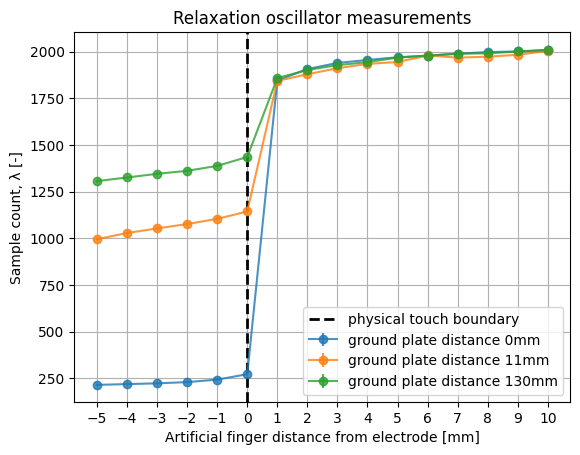

In [30]:
plt.xlabel("Artificial finger distance from electrode [mm]")
plt.ylabel("Sample count, λ [-]")
plt.xticks(comp_data[0][1])
plt.grid(True)

for (file_name, dists, means, vars, _) in comp_data:
    plt.errorbar(dists, means, yerr=np.sqrt(vars), fmt='o-', alpha=0.8, label=f"ground plate distance {file_name}")

plt.axvline(x=0, color='black', linestyle='--', linewidth=2, label="physical touch boundary")
plt.legend(loc='lower right')
plt.title("Relaxation oscillator measurements")

Plot of the distance from ground effect at 0mm distance

Text(0, 0.5, 'Sample count, λ, at artificial finger distance 0mm [-]')

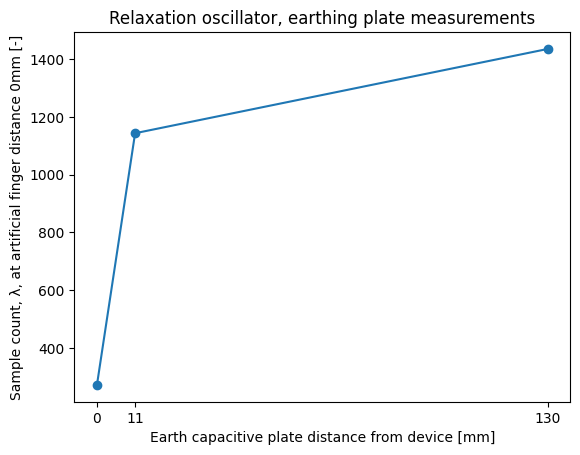

In [7]:
# get the measurement at 0mm for each 
comp_earth_distance = []
comp_earth_measurements = []
for (file_name, dists, means, vars, _) in comp_data:
    for d, m in zip(dists, means):
        if d == 0:
            earth_dist = int(file_name[:-2])
            comp_earth_distance.append(earth_dist)
            comp_earth_measurements.append(m)
            break

plt.plot(comp_earth_distance, comp_earth_measurements, marker='o')

plt.title("Relaxation oscillator, earthing plate measurements")
plt.xticks(comp_earth_distance)
plt.xlabel("Earth capacitive plate distance from device [mm]")
plt.ylabel("Sample count, λ, at artificial finger distance 0mm [-]")

Plotting the variance

Text(0, 0.5, 'STD Sample count, λ [-]')

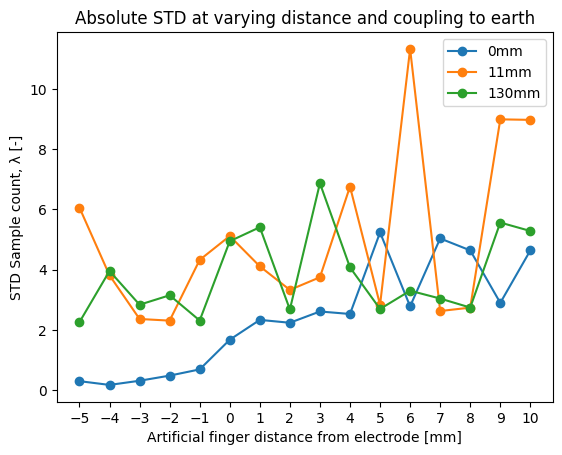

In [8]:
for (file_name, dists, means, vars, arrs) in comp_data:
    plt.plot(dists, np.sqrt(vars), marker='o', label=f'{file_name}')

plt.legend()
plt.xticks(dists)
plt.title("Absolute STD at varying distance and coupling to earth")
plt.xlabel("Artificial finger distance from electrode [mm]")
plt.ylabel("STD Sample count, λ [-]")


Text(0, 0.5, 'Standard deviation of sample count, λ, in percentage')

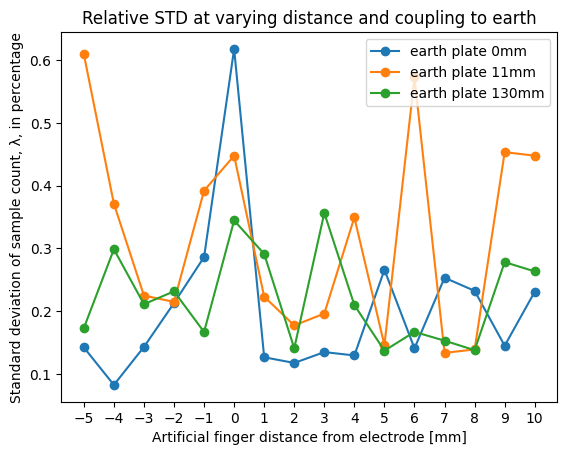

In [9]:
for (file_name, dists, means, vars, arrs) in comp_data:
    plt.plot(dists, 100*np.sqrt(vars/(np.square(means))), marker='o', label=f'earth plate {file_name}')

plt.legend(loc='upper right')
plt.xticks(dists)
plt.title("Relative STD at varying distance and coupling to earth")
plt.xlabel("Artificial finger distance from electrode [mm]")
plt.ylabel("Standard deviation of sample count, λ, in percentage")

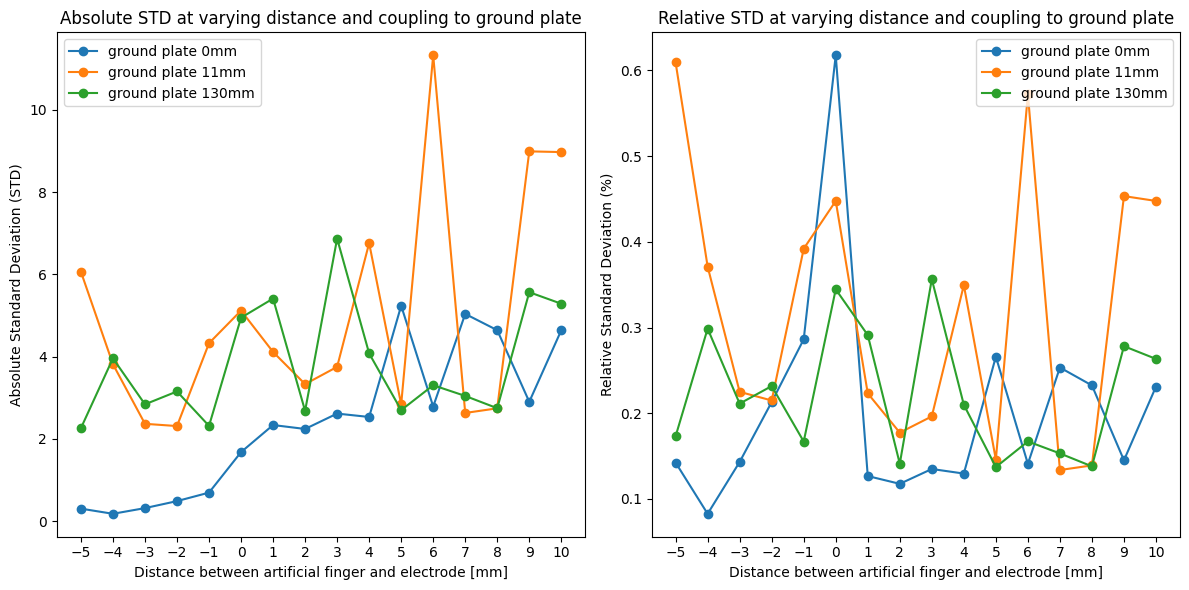

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

for (file_name, dists, means, vars, arrs) in comp_data:
    axs[0].plot(dists, np.sqrt(vars), marker='o', label=f'ground plate {file_name}')
axs[0].legend()
axs[0].set_xticks(dists)
axs[0].set_title("Absolute STD at varying distance and coupling to ground plate")
axs[0].set_xlabel("Distance between artificial finger and electrode [mm]")
axs[0].set_ylabel("Absolute Standard Deviation (STD)")

for (file_name, dists, means, vars, arrs) in comp_data:
    axs[1].plot(dists, 100 * np.sqrt(vars) / means, marker='o', label=f'ground plate {file_name}')
axs[1].legend(loc='upper right')
axs[1].set_xticks(dists)
axs[1].set_title("Relative STD at varying distance and coupling to ground plate")
axs[1].set_xlabel("Distance between artificial finger and electrode [mm]")
axs[1].set_ylabel("Relative Standard Deviation (%)")

plt.tight_layout()

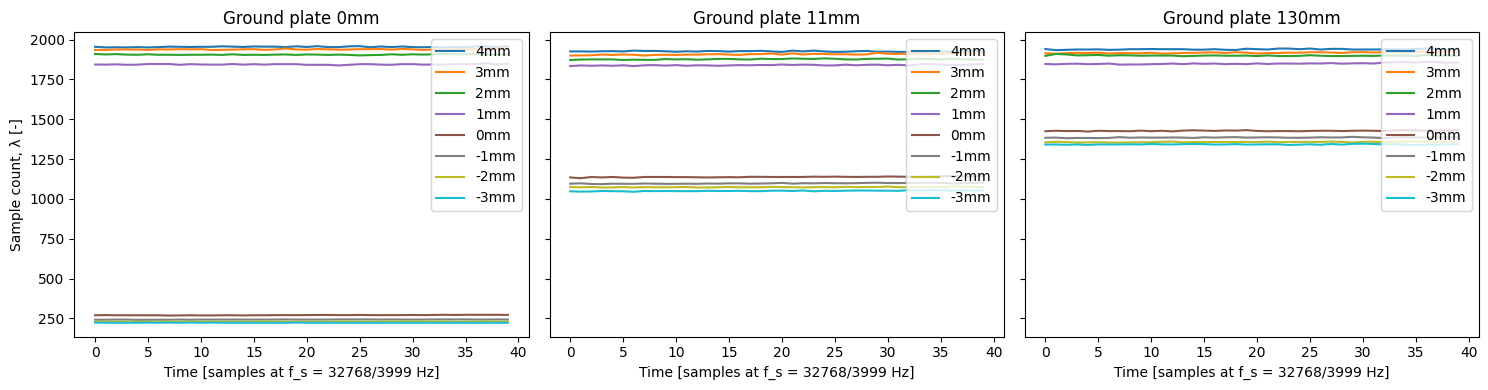

In [29]:
def plot_all_raws(adc_data):
    # Number of datasets to plot
    num_datasets = len(adc_data)

    # Create subplots with dynamic number of columns
    fig, axes = plt.subplots(1, num_datasets, figsize=(5 * num_datasets, 4), sharey=True)

    # Ensure axes is iterable (in case there's only one subplot)
    if num_datasets == 1:
        axes = [axes]

    for i, (data, ax) in enumerate(zip(adc_data, axes)):
        file_name, dists, means, vars, arrs = data

        dist_end = 4  # Set threshold for distances
        dist_start = -3

        # Use a colormap for distinguishable line colors
        cmap = plt.colormaps['tab10']  # Updated colormap access
        num_lines = sum(1 for dist in dists if dist <= dist_end and dist >= dist_start)  # Count only relevant distances
        colors = cmap(np.linspace(0, 1, num_lines))  # Generate colors for the correct number of lines

        # Plot data
        color_idx = 0
        for dist, arr in zip(dists[::-1], arrs[::-1]): # reverse to get legends in correct order
            if dist > dist_end or dist < dist_start:
                continue  # Skip irrelevant distances
            arr = arr[:40]
            color = colors[color_idx]
            ax.plot(arr, label=f'{dist}mm', color=color)
            color_idx += 1

        # Configure subplot
        ax.set_title(f"Ground plate {file_name}")
        ax.set_xlabel("Time [samples at f_s = 32768/3999 Hz]")
        if i == 0:
            ax.set_ylabel("Sample count, λ [-]")
        ax.legend(loc='upper right')

    # Adjust layout
    fig.tight_layout()
    plt.show()

# Example usage
plot_all_raws(comp_data)

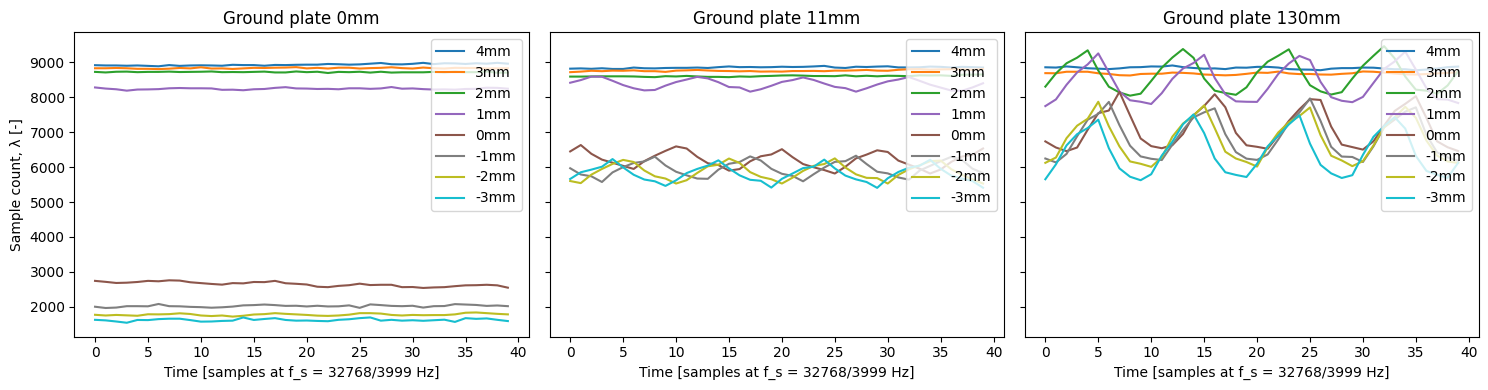

In [12]:
comp_data_130mm = adc_data[0]

def plot_all_raws(adc_data):
    # Number of datasets to plot
    num_datasets = len(adc_data)

    # Create subplots with dynamic number of columns
    fig, axes = plt.subplots(1, num_datasets, figsize=(5 * num_datasets, 4), sharey=True)

    # Ensure axes is iterable (in case there's only one subplot)
    if num_datasets == 1:
        axes = [axes]

    for i, (data, ax) in enumerate(zip(adc_data, axes)):
        file_name, dists, means, vars, arrs = data

        dist_end = 4  # Set threshold for distances
        dist_start = -3

        # Use a colormap for distinguishable line colors
        cmap = plt.colormaps['tab10']  # Updated colormap access
        num_lines = sum(1 for dist in dists if dist <= dist_end and dist >= dist_start)  # Count only relevant distances
        colors = cmap(np.linspace(0, 1, num_lines))  # Generate colors for the correct number of lines

        # Plot data
        color_idx = 0
        for dist, arr in zip(dists[::-1], arrs[::-1]): # reverse to get legends in correct order
            if dist > dist_end or dist < dist_start:
                continue  # Skip irrelevant distances
            arr = arr[:40]
            color = colors[color_idx]
            ax.plot(arr, label=f'{dist}mm', color=color)
            color_idx += 1

        # Configure subplot
        ax.set_title(f"Ground plate {file_name}")
        ax.set_xlabel("Time [samples at f_s = 32768/3999 Hz]")
        if i == 0:
            ax.set_ylabel("Sample count, λ [-]")
        ax.legend(loc='upper right')

    # Adjust layout
    fig.tight_layout()


# Example usage
plot_all_raws(adc_data)
# plt.title("Charge method raw sample values")


In [13]:
for (file_name, dists, means, vars, arrs) in adc_data:
    dist_plt = []
    autocorr_fs = []
    fft_fs = []
    for dist, arr in zip(dists, arrs):
        if dist > 3: break
        auto_f = compute_main_harmonic_autocorr(arr, Fs)
        fft_f = compute_main_harmonic_fft(arr, Fs)
        dist_plt.append(dist)
        autocorr_fs.append(auto_f)
        fft_fs.append(fft_f)

    print("res")
    print(autocorr_fs)
    print(fft_fs)

    avg_fft = np.mean(fft_fs)
    std_fft = np.std(fft_fs)

    avg_autocorr = np.mean(autocorr_fs)
    std_autocorr = np.std(autocorr_fs)

    print(f'mean fft: {avg_fft}, std: {std_fft}')
    print(f'mean autocorr: {avg_autocorr}, std: {std_autocorr}')


res
[0.8194048512128034, 0.9104498346808926, 0.9104498346808926, 0.8194048512128034, 0.8194048512128034, 0.9104498346808926, 0.8194048512128034, 1.6388097024256068, 1.6388097024256068]
[0.919740139116412, 0.9104498346808926, 0.8701644437658088, 0.8257568268036003, 0.8194048512128034, 0.07063834924248304, 0.8423788190038164, 0.04791841235162592, 0.07125259575763507]
mean fft: 0.5975226968816751, std: 0.37917897115656257
mean autocorr: 1.0318431459716786, std: 0.3268614938923314
res
[0.8194048512128034, 0.8194048512128034, 0.8194048512128034, 0.8194048512128034, 0.8194048512128034, 0.9104498346808926, 0.8194048512128034, 0.2731349504042678, 2.048512128032008]
[0.8560946206700931, 0.8535467200133368, 0.8252998501423919, 0.8676051365782623, 0.8625314223292666, 0.8625314223292667, 0.8194048512128033, 0.09418446565664407, 0.07187761852743889]
mean fft: 0.6792306786066116, std: 0.3191119640541074
mean autocorr: 0.9053917800437765, std: 0.4410670047492089
res
[0.8194048512128034, 0.91044983468

## ADC

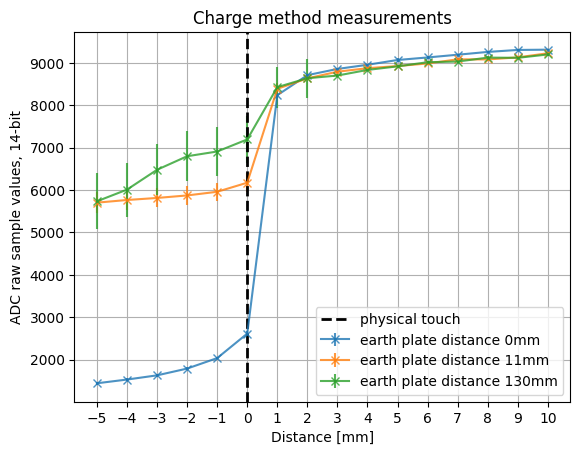

In [14]:
plt.title("Charge method measurements")
plt.xlabel("Distance [mm]")
plt.ylabel("ADC raw sample values, 14-bit")
plt.xticks(comp_data[0][1])
plt.grid(True)

for (file_name, dists, means, vars, _) in adc_data:
    plt.errorbar(dists, means, yerr=np.sqrt(vars), fmt='x-', alpha=0.8, label=f"earth plate distance {file_name}")

plt.axvline(x=0, color='black', linestyle='--', linewidth=2, label="physical touch")

plt.legend(loc='lower right')

Text(0, 0.5, 'Sample count, λ, at artificial finger distance 0mm [-]')

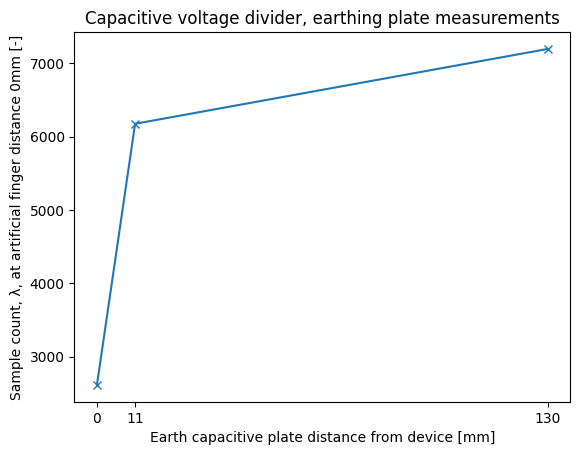

In [15]:
# get the measurement at 0mm for each 
adc_earth_distance = []
adc_earth_measurements = []
for (file_name, dists, means, vars, _) in adc_data:
    for d, m in zip(dists, means):
        if d == 0:
            earth_dist = int(file_name[:-2])
            adc_earth_distance.append(earth_dist)
            adc_earth_measurements.append(m)
            break

plt.plot(adc_earth_distance, adc_earth_measurements, marker='x')

plt.title("Capacitive voltage divider, earthing plate measurements")
plt.xticks(adc_earth_distance)
plt.xlabel("Earth capacitive plate distance from device [mm]")
plt.ylabel("Sample count, λ, at artificial finger distance 0mm [-]")

Text(0, 0.5, 'Sample count, λ, variance [-]')

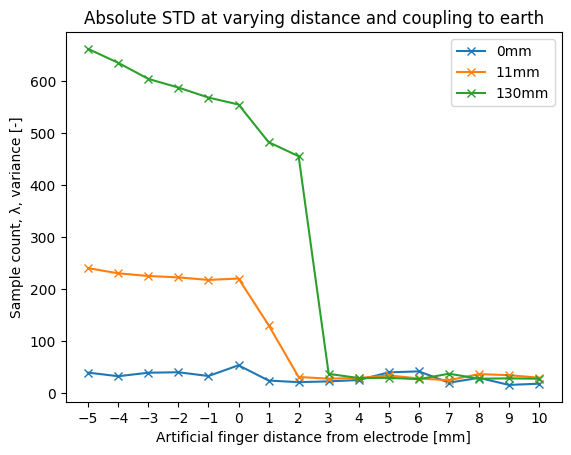

In [16]:
for (file_name, dists, means, vars, arrs) in adc_data:
    plt.plot(dists, np.sqrt(vars), marker='x', label=f'{file_name}')

plt.legend()
plt.xticks(dists)
plt.title("Absolute STD at varying distance and coupling to earth")
plt.xlabel("Artificial finger distance from electrode [mm]")
plt.ylabel("Sample count, λ, variance [-]")

Text(0, 0.5, 'Sample count, λ, variance [-]')

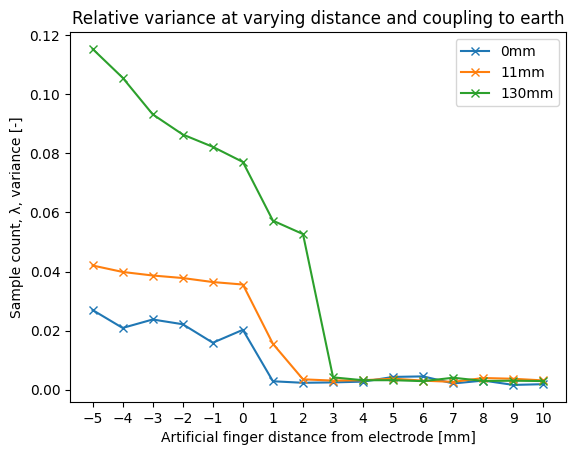

In [17]:
for (file_name, dists, means, vars, arrs) in adc_data:
    plt.plot(dists, np.sqrt(vars/(np.square(means))), marker='x', label=f'{file_name}')

plt.legend()
plt.xticks(dists)
plt.title("Relative variance at varying distance and coupling to earth")
plt.xlabel("Artificial finger distance from electrode [mm]")
plt.ylabel("Sample count, λ, variance [-]")

In [18]:
for (file_name, dists, means, vars, arrs) in adc_data:
    dist_plt = []
    autocorr_fs = []
    fft_fs = []
    for dist, arr in zip(dists, arrs):
        if dist > 3: break
        auto_f = compute_main_harmonic_autocorr(arr, Fs)
        fft_f = compute_main_harmonic_fft(arr, Fs)
        dist_plt.append(dist)
        autocorr_fs.append(auto_f)
        fft_fs.append(fft_f)

    print("res")
    print(autocorr_fs)
    print(fft_fs)

    avg_fft = np.mean(fft_fs)
    avg_autocorr = np.mean(autocorr_fs)

    print(f'mean fft: {avg_fft}')
    print(f'mean autocorr: {avg_autocorr}')



res
[0.8194048512128034, 0.9104498346808926, 0.9104498346808926, 0.8194048512128034, 0.8194048512128034, 0.9104498346808926, 0.8194048512128034, 1.6388097024256068, 1.6388097024256068]
[0.919740139116412, 0.9104498346808926, 0.8701644437658088, 0.8257568268036003, 0.8194048512128034, 0.07063834924248304, 0.8423788190038164, 0.04791841235162592, 0.07125259575763507]
mean fft: 0.5975226968816751
mean autocorr: 1.0318431459716786
res
[0.8194048512128034, 0.8194048512128034, 0.8194048512128034, 0.8194048512128034, 0.8194048512128034, 0.9104498346808926, 0.8194048512128034, 0.2731349504042678, 2.048512128032008]
[0.8560946206700931, 0.8535467200133368, 0.8252998501423919, 0.8676051365782623, 0.8625314223292666, 0.8625314223292667, 0.8194048512128033, 0.09418446565664407, 0.07187761852743889]
mean fft: 0.6792306786066116
mean autocorr: 0.9053917800437765
res
[0.8194048512128034, 0.9104498346808926, 0.9104498346808926, 0.8194048512128034, 0.9104498346808926, 0.9104498346808926, 0.819404851212

## Combine

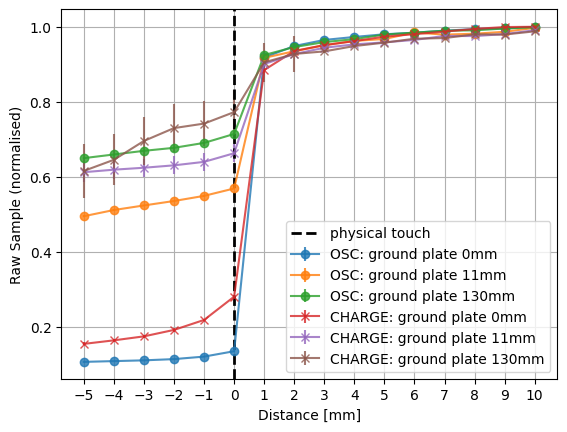

In [34]:
plt.xlabel("Distance [mm]")
plt.ylabel("Raw Sample (normalised)")
plt.xticks(comp_data[0][1])
plt.grid(True)

for (file_name, dists, means, vars, _) in comp_data:
    plt.errorbar(dists, means/comp_lambda0, yerr=np.sqrt(vars)/comp_lambda0, fmt='o-', alpha=0.8, label=f"OSC: ground plate {file_name}")

for (file_name, dists, means, vars, _) in adc_data:
    plt.errorbar(dists, means/adc_lambda0, yerr=np.sqrt(vars)/adc_lambda0, fmt='x-', alpha=0.8, label=f"CHARGE: ground plate {file_name}")

plt.axvline(x=0, color='black', linestyle='--', linewidth=2, label="physical touch")

plt.legend()

Text(0, 0.5, 'Sample count, λ, at artificial finger distance 0mm [-]')

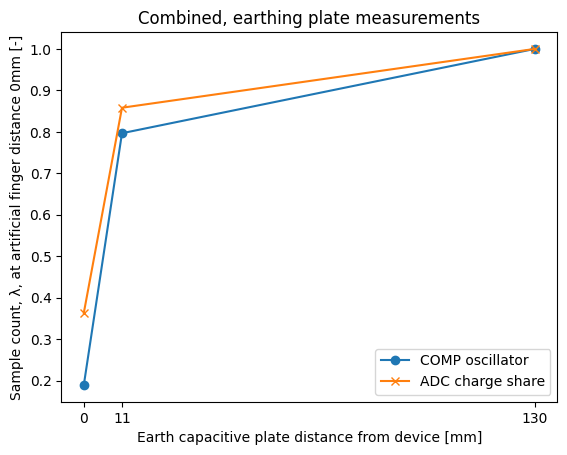

In [20]:
plt.plot(comp_earth_distance, comp_earth_measurements/comp_earth_measurements[-1], marker='o', label="COMP oscillator")
plt.plot(adc_earth_distance, adc_earth_measurements/adc_earth_measurements[-1], marker='x', label="ADC charge share")

plt.legend(loc='lower right')
plt.title("Combined, earthing plate measurements")
plt.xticks(adc_earth_distance)
plt.xlabel("Earth capacitive plate distance from device [mm]")
plt.ylabel("Sample count, λ, at artificial finger distance 0mm [-]")

Text(0, 0.5, 'Relative Standard deviation (STD) (%)')

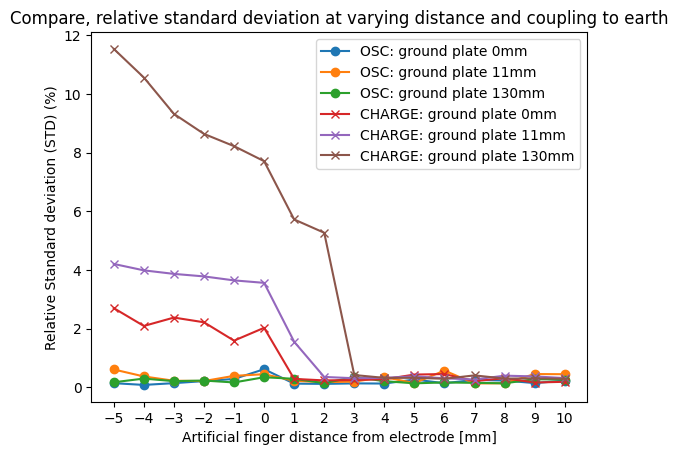

In [35]:
for (file_name, dists, means, vars, arrs) in comp_data:
    plt.plot(dists, 100 * np.sqrt(vars) / means, marker='o', label=f'OSC: ground plate {file_name}')
for (file_name, dists, means, vars, arrs) in adc_data:
    plt.plot(dists, 100 * np.sqrt(vars) / means, marker='x', label=f'CHARGE: ground plate {file_name}')

plt.legend()
plt.xticks(dists)
# plt.yscale('log')

plt.title("Compare, relative standard deviation at varying distance and coupling to earth")
plt.xlabel("Artificial finger distance from electrode [mm]")
plt.ylabel("Relative Standard deviation (STD) (%)")


Text(0, 0.5, 'Sample count, λ, variance [-]')

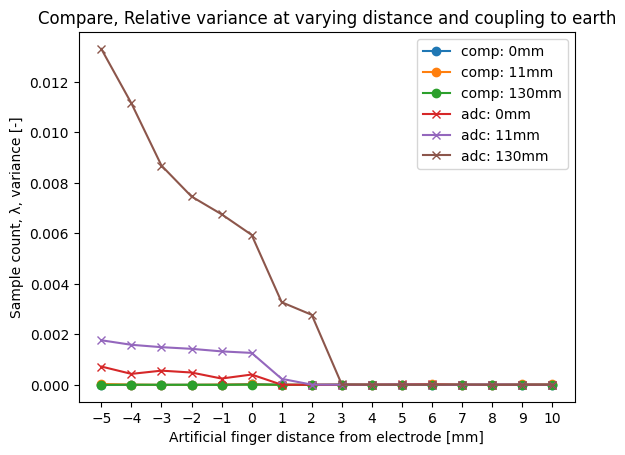

In [22]:
for (file_name, dists, means, vars, arrs) in comp_data:
    plt.plot(dists, vars/(np.square(means)), marker='o', label=f'comp: {file_name}')
for (file_name, dists, means, vars, arrs) in adc_data:
    plt.plot(dists, vars/(np.square(means)), marker='x', label=f'adc: {file_name}')

plt.legend()
plt.xticks(dists)
plt.title("Compare, Relative variance at varying distance and coupling to earth")
plt.xlabel("Artificial finger distance from electrode [mm]")
plt.ylabel("Sample count, λ, variance [-]")

# Transformet, proportional to distance

In [23]:
def T(d, l): return ((1/d) - (1/l))
# def T(d, l): return l - d

comp_T = [T(means, comp_lambda0) for (file_name, dists, means, vars, _) in comp_data]
adc_T = [T(means, adc_lambda0) for (file_name, dists, means, vars, _) in adc_data]

Plotting distance directly to capacitance change

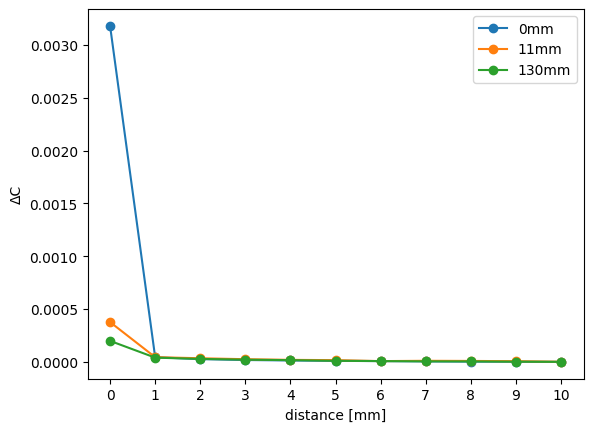

In [24]:
plt.xlabel("distance [mm]")
plt.ylabel("ΔC")
# plt.yticks([])
plt.xticks(comp_data[0][1])

for (file_name, dists, means, vars, _), d in zip(comp_data, comp_T):
    # only plot until we touch the plate
    dist_short = dists[5:]
    data_short = d[5:]
    plt.plot(dist_short, data_short, label=file_name, marker='o')

# plt.ylim(bottom=0,top=0.4)
plt.legend()

Changing the distance to be inverse, such that we should have a proportional value between them

[ 0  1  2  3  4  5  6  7  8  9 10]
[3.17921273e-03 4.43461626e-05 2.69117898e-05 1.80988144e-05
 1.38566615e-05 1.01316587e-05 7.95453022e-06 5.22874648e-06
 3.06367563e-06 2.24406249e-06 0.00000000e+00]
[ 214.96842105  219.          223.11538462  229.7311828   243.125
  271.97058824 1845.01298701 1906.33333333 1938.90789474 1954.98795181
 1969.32926829 1977.80909091 1988.52941176 1997.12765957 2000.40206186
 2009.42241379]
2009.4224137931035


/var/folders/29/wsbyz8p15ngd8x_sm94z_6s80000gn/T/ipykernel_23809/2953229876.py:18: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/dist_short, data_short, label=f'ground distance {file_name}', marker='o')


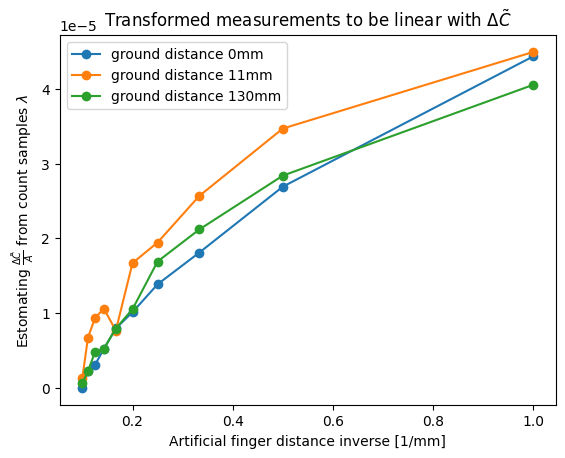

In [26]:
plt.xlabel("Artificial finger distance inverse [1/mm]")
plt.ylabel(r"Estomating $\frac{\Delta \tilde{C}}{A}$ from count samples $\lambda$")
plt.title(r"Transformed measurements to be linear with $\Delta \tilde{C}$")
# plt.yticks([])
# plt.xticks(1/comp_data[0][1][6:])


for (file_name, dists, means, vars, _), d in zip(comp_data, comp_T):
    # only plot until we touch the plate
    dist_short = dists[5:]
    data_short = d[5:]

    if file_name == '0mm':
        print(dist_short)
        print(data_short)
        print(means)
        print(comp_lambda0)
    plt.plot(1/dist_short, data_short, label=f'ground distance {file_name}', marker='o')

# plt.ylim(bottom=0,top=0.4)
plt.legend()